In [1]:
# This notebook includes model developement with a new target variable as Is_Satisfied_With_RemoteWork

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [3]:
file_path = 'Data/Cleaned_Impact_of_Remote_Work_on_Mental_Health.csv'
df = pd.read_csv(file_path)

#### Data cleanup for unrelated values for Satisfaction_with_Remote_Work

In [4]:
df = df.loc[df['Work_Location'] != 'Onsite']

#### Remove outliers

In [5]:
df = df.drop(df[(df['Satisfaction_with_Remote_Work'] == 'Unsatisfied') & (df['Work_Life_Balance_Rating'] > 3)].index)

#### Encoding

In [6]:
df['Stress_Level_Encoded'] = df['Stress_Level'].apply(lambda x: 2 if x == 'Low' else (1 if x == 'Medium' else 0))

In [7]:
def classify_satisfaction_with_remotework(row):
    if row['Satisfaction_with_Remote_Work'] == 'Satisfied' and (row['Stress_Level_Encoded'] > 1 or row['Work_Life_Balance_Rating'] > 3):
        return 1
    elif row['Satisfaction_with_Remote_Work'] == 'Neutral' and (row['Stress_Level_Encoded'] > 1 or row['Work_Life_Balance_Rating'] > 3):
        return 1
    else:
        return 0

df['Is_Satisfied_With_RemoteWork'] = df.apply(classify_satisfaction_with_remotework, axis = 1)

In [8]:
features_to_drop = ['Employee_ID', 'Satisfaction_with_Remote_Work', 'Is_Satisfied_With_RemoteWork', 'Stress_Level', 'Work_Location', 
                    'Social_Isolation_Rating', 'Physical_Activity', 'Mental_Health_Condition', 'Job_Role', 'Industry', 
                    'Access_to_Mental_Health_Resources', 'Productivity_Change', 'Region']

In [9]:
X = pd.get_dummies(df.drop(features_to_drop, axis = 1), drop_first = True)
y = df['Is_Satisfied_With_RemoteWork']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
class_distribution = df['Is_Satisfied_With_RemoteWork'].value_counts()
print(class_distribution)

Is_Satisfied_With_RemoteWork
0    1580
1    1301
Name: count, dtype: int64


## Using RandomForest

#### Tuning

In [12]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def RandomForest_Bayesian(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(
        max_depth = int(max_depth),
        n_estimators = int(n_estimators),
        min_samples_split = int(min_samples_split),
        min_samples_leaf = int(min_samples_leaf),
        class_weight = 'balanced',
        random_state = 42
    )
    
    # Performing cross-validation
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'f1')
    return np.mean(scores)

param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}

optimizer = BayesianOptimization(
    f = RandomForest_Bayesian,
    pbounds = param_bounds,
    random_state = 42,
    verbose = 2
)

optimizer.maximize(init_points = 20, n_iter = 50)
print("Best Parameters:", optimizer.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9266    | 9.367     | 4.803     | 7.856     | 199.7     |
| 2         | 0.9263    | 5.652     | 1.624     | 2.465     | 266.5     |
| 3         | 0.9232    | 13.22     | 3.832     | 2.165     | 292.5     |
| 4         | 0.9154    | 17.15     | 1.849     | 3.455     | 95.85     |
| 5         | 0.9233    | 8.172     | 3.099     | 5.456     | 122.8     |
| 6         | 0.9218    | 13.4      | 1.558     | 4.337     | 141.6     |
| 7         | 0.9248    | 10.75     | 4.141     | 3.597     | 178.6     |
| 8         | 0.918     | 13.07     | 1.186     | 6.86      | 92.63     |
| 9         | 0.9273    | 4.106     | 4.796     | 9.725     | 252.1     |
| 10        | 0.9232    | 8.178     | 1.391     | 7.474     | 160.0     |
| 11        | 0.9263    | 5.075     | 2.981     | 2.275     | 277.3     |
| 12        | 0.9248    | 7.399     | 

#### Train

In [13]:
rf_model = RandomForestClassifier(
    n_estimators = int(optimizer.max['params']['n_estimators']),
    max_depth = int(optimizer.max['params']['max_depth']),
    min_samples_split = int(optimizer.max['params']['min_samples_split']),
    min_samples_leaf = int(optimizer.max['params']['min_samples_leaf']),
    class_weight = 'balanced',
    random_state = 42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=4,
                       min_samples_split=3, n_estimators=60, random_state=42)

#### Predict

In [14]:
y_pred = rf_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       333
           1       0.88      1.00      0.93       244

    accuracy                           0.94       577
   macro avg       0.94      0.95      0.94       577
weighted avg       0.95      0.94      0.94       577

Confusion Matrix:
 [[299  34]
 [  0 244]]


#### Feature Importance

In [15]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

print(feature_importance)

                            Feature  Importance
4          Work_Life_Balance_Rating    0.538617
6              Stress_Level_Encoded    0.327811
1               Years_of_Experience    0.028418
0                               Age    0.027364
3        Number_of_Virtual_Meetings    0.017508
7                       Gender_Male    0.016104
2             Hours_Worked_Per_Week    0.015069
5   Company_Support_for_Remote_Work    0.011162
9          Gender_Prefer not to say    0.006235
8                 Gender_Non-binary    0.005675
11               Sleep_Quality_Poor    0.005018
10               Sleep_Quality_Good    0.001018


#### Result Visualization

In [16]:
y_probs = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

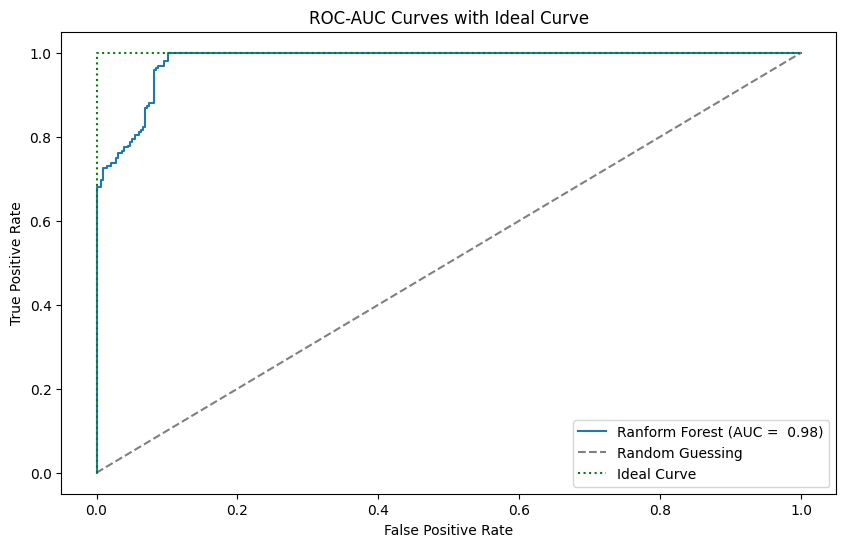

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(fpr, tpr, label = f'Ranform Forest (AUC = {auc : .2f})', linestyle = '-')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guessing')
plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'green', label = 'Ideal Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves with Ideal Curve')
plt.legend(loc = 'lower right')
plt.show()